In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import bs4
import codecs
import re
import random
import pickle as pkl
import json
import re

**1) Data scraping and cleaning**  

**1.A Selecting websites**  
By looking at the websites, we have found that structurally and content-wise they are highly diverse. Each website requires a custom scraper to be implemented, and the information available may not be consistent across different websites.  
Hence the first step in our cleaning procedure is to identify the websites recipe data is going to be collected from, and choose a set of websites which offer a good representation of the entire dataset, in terms of data volume and consistent attributes to be analyzed in the later steps.

---


In [3]:
links = os.listdir('recipePages')

In [ ]:
# Loading website data for initial analysis
# NOTE: Long running task, it is recommended to load the results directly by executing the next block instead
website_map = dict({})
i = 0
for link in links:

    f = codecs.open('./recipePages/' + link, 'r', 'utf-8', errors='ignore')
    document = BeautifulSoup(f.read(),'html.parser')
    try:
        a = document.body.find('a')
        website_name = a['href']
        website_url = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', website_name)
        
        if website_url!=[]:
            website_url = website_url[0]
            if website_url in website_map:
                website_map[website_url].append(link)
            else:
                website_map[website_url] = [link]
        
        if (i%10000 == 0) and (i>0) :
            with open('./pickles/recepie_to_websites' + str(i) + '.pkl', 'wb') as f:
                pkl.dump(website_map, f)
        
        i+=1
        
    except:
           continue

with open('./pickles/recepe_to_websites.pkl', 'wb') as f:
    pkl.dump(website_map, f)

In [4]:
# Load initial analysis results directly
with open('./pickles/recepe_to_websites.pkl', 'rb') as f:
    website_map = pkl.load(f) # a map having for each url a list of all html files belonging to it

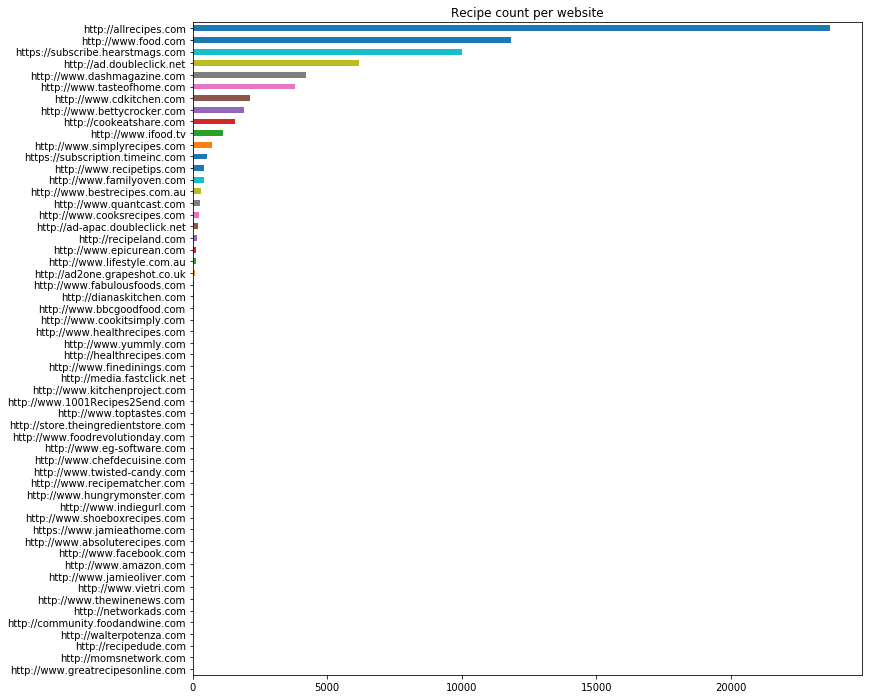

In [46]:
# Display recipe count distribution across all websites
plt.rcParams['figure.figsize'] = [12,12]
website_distribution = dict()
for key in website_map.keys():
    website_distribution[key] = len(website_map[key])
dist_ser = pd.Series(website_distribution).sort_values()
dist_ser.plot(kind='barh', title='Recipe count per website')

In [47]:
# Calculate the number of recipes in the top 3 websites
top3 = dist_ser[-3:].sum() / dist_ser.sum() * 100
print("Top 3 webpages contain %.2f%% of all recipes." % top3)

Top 3 webpages contain 64.66% of all recipes.


---

Based on the above analysis, we decided to choose the three websites with the highest number of recipes, which roughly represent 2/3rd of all recipes available.

---

**1.B Scraping the websites**  
The selected websites display the recipes in different format, requiring individual scrapers to be implemented in order to extract the data for analysis. We were interested to extract common attributes which may influence the reviews, such as:
- category
- preparation time  
- cooking time  
- difficulty

As well as other attributes describing the recipe and its reviews:
- name
- review
- review date
- rating

---


In [ ]:
# Scraper for https://subscribe.hearstmags.com
def parse_food_network(links):
    
    final_res = []
    applied = lambda x: x.contents[0] if isinstance(x,bs4.element.Tag) else x
    
    for link in links:
        
        try:
            f = codecs.open('./recipePages/' + link, 'r', 'utf-8', errors='ignore')
            document = BeautifulSoup(f.read(),'html.parser')

            recepie_name = document.find('h1',{'class':'fn'}).contents[0]

            category = map(lambda x : x.contents [0] ,document.find("div", {"class": "more"}).find('ul').findAll('a'))

            rating_info = int(document.find("div",{"class":"rm-block lead hreview-aggregate review"}).find('div')['title'])

            preparation_time = document.find("div",{"class":"rm-block-wrap"})
            prep_time = re.findall('\d+',preparation_time.find('dd',{'class':'prepTime clrfix'}).find('span').contents[0])[0]
            cook_time = re.findall('\d+',preparation_time.find('dd',{'class':'cookTime clrfix'}).find('span').contents[0])[0]
            diff_level = document.findAll('dd',{'class':'clrfix'})[-1:][0].contents[0]

            reviews = map(lambda x : x.contents[0].strip(),document.findAll('p',{'class':'quote'}))
            review_dates = document.findAll('div',{'class':'about-recipe-info'})
            review_dates = map(lambda x : x.findAll('p')[-1].contents[0][2:],review_dates)
            
            review_info = list(zip(reviews,review_dates))
            
            for review in review_info:

                data = {
                    'name':recepie_name,
                    'category':list(category),
                    'review':review[0],
                    'review_date':review[1],
                    'rating':rating_info,
                    'prep_time':prep_time,
                    'cook_time':cook_time,
                    'difficulty':diff_level
                }
                final_res.append(data)
        
        except: 
            continue
    
    return final_res

In [ ]:
# Scraping https://subscribe.hearstmags.com
# NOTE: Long running task, result can be opened directly from json file
food_net_result = parse_food_network(website_map['https://subscribe.hearstmags.com'])
with open('./pickles/food_net.json', 'w') as fout:
    json.dump(food_net_result, fout)

NOTE: files of the dataset can be opened directly in the browser using the following code
```
  import webbrowser  
  new=2  
  urls = [website_map['https://subscribe.hearstmags.com'][0]]  
  for link in urls:  
    webbrowser.open('recipePages/'+ link,new=new) 
```

In [ ]:
# Scraper for http://allrecipes.com
def parse_allrecepies(links):
    
    final_res = []
    
    for link in links:
        
        try:
            f = codecs.open('./recipePages/' + link, 'r', 'utf-8', errors='ignore')
            document = BeautifulSoup(f.read(),'html.parser')

            recepie_name    = document.find('span',{'class','itemreviewed'}).contents[0]
            rating          = int(re.findall('\d',document.find('p',{'class':'reviewP'}).find('img')['title'])[0])

            serving_info    = document.find('div',{'class':'servings-form'}).find('input')['value']
            
            timing_data     = document.find('div',{'class':'times'})
            if timing_data is not None:
                prep_time  = timing_data.find('span',{'class':'prepTime'}).find('span')['title'][2:]
                cook_time  = timing_data.find('span',{'class':'cookTime'}).find('span')['title'][2:]
                total_time = timing_data.find('span',{'class':'totalTime'}).find('span')['title'][2:]
            else:
                prep_time  = -1
                cook_time  = -1
                total_time = -1
                
            

            nutrition_facts  = document.find('div',{'id':'nutri-info'}).findAll('span')
            nutrition_facts  = map(lambda x : {x['class'][0] : x.contents[0]} ,nutrition_facts)
            nutrition_info   = dict()
            for subDict in nutrition_facts:
                key = subDict.keys()[0]
                nutrition_info[key] = subDict[key]

            reviews          = document.findAll('div',{'class':'listItemReviewMini'})
            reviews          = map(lambda x : x.contents[0].strip(),reviews)
            
            review_date      = document.findAll('div',{'class','recreview'})
            review_date      = map(lambda x : x.find('div',{'class','review'}).contents[0].split('\n')[2].strip(),review_date) 
                                       

            review_info = list(zip(reviews,review_date))
                
                
            for review in review_info:
                data = {
                    'name': recepie_name,
                    'rating': rating,
                    'servings':serving_info,
                    'review' : review[0],
                    'prep_time':prep_time,
                    'cook_time':cook_time,
                    'total_time':total_time,
                    'review_date':review[1]
                }
                data.update(nutrition_info)
                final_res.append(data)
        
        except:
            continue
    
    return final_res

In [ ]:
# Scraping http://allrecipes.com
# NOTE: Long running task, result can be opened directly from json file
all_recipe_result = parse_allrecepies(website_map['http://allrecipes.com'])
with open('./pickles/all_recipe11.json', 'w') as fout:
      json.dump(all_recipe_result, fout)

In [ ]:
# Scraper for http://www.food.com
def parse_food_com(links):
    
    final_res = []
    
    for link in links:

        try:
            f = codecs.open('./recipePages/' + link, 'r', 'utf-8', errors='ignore')
            document = BeautifulSoup(f.read(),'html.parser')

            recepie_name     = document.find('h1',{'itemprop':'name'}).contents[0]

            document_posted  = document.find('div',{'class':'addedwhen clrfix'}).find('meta')['content']

            categories       = document.find('p',{"class","recipe-cats"}).findAll('span',{'itemprop':'recipeCategory'})
            categories       = map(lambda x: x.contents[0],categories)

            preparation_time = document.find('div',{'class':'ckTime clrfix'}).find('div',{'class':"ct-e"}).findAll('p')
            preparation_time = map(lambda x : x.contents,preparation_time)
            preparation_time = map(lambda x: {x[0]['itemprop'] : x[1]},preparation_time)

            num_servings     = document.find('select').find('option',{'class':"select-title"}).contents[0]

            nutrition_facts  = document.find('div',{'itemprop':'nutrition'}).findAll('span')
            nutrition_facts  = filter(lambda x : x.has_attr('itemprop'),nutrition_facts)
            nutrition_facts  = map(lambda x : {x['itemprop']:x.contents[0]},nutrition_facts)
            resulting_facts  = dict()
            for subdict in nutrition_facts:
                key = subdict.keys()[0]
                resulting_facts[key] = subdict[key]

            
            user_reviews     = document.findAll('span',{'itemprop':'description'})
            user_reviews     = map(lambda x : x.contents[0],user_reviews)
            
            review_dates     = document.findAll('li',{'itemprop':'reviews'})
            review_dates     = map(lambda x: x.find('meta')['content'],review_dates)

            review_info      = list(zip(user_reviews,review_dates))
            
            
            for review in review_info:

                data = {
                    'name'    : recepie_name,
                    'date'    : document_posted,
                    'category': categories,
                    'review'  : review[0],
                    'review_date': review[1],
                    'servings': num_servings
                }
                data.update(preparation_time[0])
                data.update(preparation_time[1])
                data.update(resulting_facts)
                final_res.append(data)
        except:
            continue
            
        
    return final_res

In [ ]:
# Scraping http://www.food.com
# NOTE: Long running task, result can be opened directly from json file
food_com_result = parse_food_com(website_map['http://www.food.com'])
with open('./pickles/food_com7.json', 'w') as fout:
    json.dump(food_com_result, fout)

In [ ]:
json_dirs = os.listdir('./pickles')[1:]
data = []
for dirs in json_dirs:
    
    sub_dir = os.listdir('./pickles/' + dirs + '/')
    recipe_data = []
    for json_file in sub_dir:
        file_info = json.load(open('./pickles/' + dirs + '/' + json_file))
        recipe_data = recipe_data + file_info
    
    df = pd.DataFrame(recipe_data)
    data.append(df)

In [ ]:
data[0].to_json('./pickles/all_recipe_df.json')
data[1].to_json('./pickles/food_com_df.json')

In [ ]:
website_map['http://www.food.com'][0]

---

**1.C Data cleaning**  
See `Prepocessing.ipynb` for the cleaning steps, converting nutrition values to a consistent format, calculating preparation time values in minutes, and converting review dates to a common format.

---

### Next steps ###

---

**2) Sentiment analysis**  

**2.A Analysis**  
For each review, process the review text and determine the sentiment of the content.

**2.B Validation**  
Cross-check the analysis results with the review rating, in order to validate it's correctness. Fine tune if necessary.

---

**3) Visualize correlations**  
Analyse the correlations between the attributes, looking for meaningful connections between properties of the recipe and the corresponding feedback.

---

**4) Conclusion**  
Draw a conclusion whether there are certain strategies when publishing a recipe in order to maximise positive reviews.

---

**5) Documentation**  

**5.A Report**  
Create a Pdf document summarizing the problem, the method of the study and its results.

**5.B Presentation**  
Create a poster and prepare the presentation by the team.